In [27]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt



In [28]:


data = pd.read_csv('./meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Bollinger Bands
window = 20
data['BB_middle'] = data['Close'].rolling(window=window).mean()
data['BB_upper'] = data['BB_middle'] + 2*data['Close'].rolling(window=window).std()
data['BB_lower'] = data['BB_middle'] - 2*data['Close'].rolling(window=window).std()

# Price changes
data['Price_Change'] = data['Close'].pct_change()
data['Price_Change_5d'] = data['Close'].pct_change(periods=5)
data['Price_Change_21d'] = data['Close'].pct_change(periods=21)

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()


# Calculate RSI
# def compute_RSI(data, window=14):
#     delta = data['Close'].diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
#     RS = gain / loss
#     return 100 - (100 / (1 + RS))

# data['RSI_14'] = compute_RSI(data)

def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,...,EMA for 50 days,BB_middle,BB_upper,BB_lower,Price_Change,Price_Change_5d,Price_Change_21d,MACD,Signal_Line,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,...,30.538853,29.237800,34.169255,24.306345,-0.023413,-0.194783,-0.261798,-1.525536,-0.894611,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,...,30.192623,28.784750,34.691542,22.877958,-0.062203,-0.236907,-0.301817,-1.869091,-1.089507,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,...,29.827422,28.268750,35.028615,21.508885,-0.038231,-0.288344,-0.321439,-2.183168,-1.308239,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,...,29.443602,27.697250,35.208463,20.186037,-0.040230,-0.253492,-0.357692,-2.471369,-1.540865,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,...,29.116010,27.165250,34.975085,19.355415,0.052395,-0.110314,-0.329838,-2.585243,-1.749740,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,...,64.769416,66.626865,69.652270,63.601460,0.014325,0.022091,0.078620,1.037495,0.876412,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,...,64.945909,66.821865,70.004815,63.638915,-0.001873,0.031341,0.073953,1.134074,0.927944,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,...,65.194697,67.100365,70.808733,63.391997,0.029161,0.053651,0.090561,1.357958,1.013947,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,...,65.578435,67.477365,72.596013,62.358717,0.051760,0.129049,0.140901,1.812249,1.173608,71.536342


In [29]:
# Select key features
selected_features = ['Close', 'Volume', 'EMA for 50 days', 'MACD', 'RSI_14']

# Scale the data
numeric_data = data[selected_features]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Create sequences for training
sequence_length = 90  # Number of time steps to look back
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])  # Predict 'Close' price
    
X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader
batch_size = 64
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# test

In [30]:
# Transformer Model parameters
input_dim = X.shape[2]  # Number of features
d_model = 128          # Transformer dimension
nhead = 8             # Number of attention heads
num_layers = 2        # Number of transformer layers
lstm_hidden_dim = 64

# Create model components
input_projection = nn.Linear(input_dim, d_model)

encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=nhead,
    dropout=0.1,
    batch_first=True
)

transformer_encoder = nn.TransformerEncoder(
    encoder_layer,
    num_layers=num_layers
)

lstm = nn.LSTM(
    input_size=d_model,
    hidden_size=lstm_hidden_dim,
    num_layers=1,
    batch_first=True
)


fc = nn.Linear(lstm_hidden_dim, 1)

# Set up training parameters
criterion = nn.MSELoss()

# Combine into a sequential model
# model = nn.Sequential(
#     input_projection,
#     transformer_encoder,
#     nn.Flatten(start_dim=0, end_dim=1),
#     lstm,
#     nn.Flatten(start_dim=0, end_dim=1),
#     fc
# )



In [31]:
# Set up training parameters

# Combine all parameters from different components
all_parameters = list(input_projection.parameters()) + \
                list(transformer_encoder.parameters()) + \
                list(lstm.parameters()) + \
                list(fc.parameters())
optimizer = torch.optim.Adam(all_parameters, lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


num_epochs = 50

# Training loop
best_val_loss = float('inf')
patience_counter = 0
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        # 1. Input projection
        x = input_projection(batch_X)
        # 2. Transformer
        x = transformer_encoder(x)
        # 3. LSTM
        lstm_out, _ = lstm(x)
        # 4. Take last hidden state
        last_hidden = lstm_out[:, -1, :]
        # 5. Final prediction
        outputs = fc(last_hidden)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            
            # Forward pass
            x = input_projection(batch_X)
            x = transformer_encoder(x)
            lstm_out, _ = lstm(x)
            last_hidden = lstm_out[:, -1, :]
            outputs = fc(last_hidden)
            
            loss = criterion(outputs.squeeze(), batch_y)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    # scheduler step
    scheduler.step(avg_val_loss)
    
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}')
    
    # Save best model states
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = {
            'input_projection': input_projection.state_dict(),
            'transformer_encoder': transformer_encoder.state_dict(),
            'lstm': lstm.state_dict(),
            'fc': fc.state_dict()
        }
        torch.save(best_model_state, 'best_model.pth')

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Train Loss: 0.0239, Val Loss: 0.0174
Epoch [2/50], Train Loss: 0.0014, Val Loss: 0.0067
Epoch [3/50], Train Loss: 0.0008, Val Loss: 0.0092
Epoch [4/50], Train Loss: 0.0006, Val Loss: 0.0101
Epoch [5/50], Train Loss: 0.0007, Val Loss: 0.0069
Epoch [6/50], Train Loss: 0.0006, Val Loss: 0.0069
Epoch [7/50], Train Loss: 0.0004, Val Loss: 0.0084
Epoch [8/50], Train Loss: 0.0005, Val Loss: 0.0068
Epoch [9/50], Train Loss: 0.0003, Val Loss: 0.0078
Epoch [10/50], Train Loss: 0.0003, Val Loss: 0.0074
Epoch [11/50], Train Loss: 0.0003, Val Loss: 0.0075
Epoch [12/50], Train Loss: 0.0003, Val Loss: 0.0078
Epoch [13/50], Train Loss: 0.0003, Val Loss: 0.0094
Epoch [14/50], Train Loss: 0.0003, Val Loss: 0.0068
Epoch [15/50], Train Loss: 0.0002, Val Loss: 0.0080
Epoch [16/50], Train Loss: 0.0003, Val Loss: 0.0077
Epoch [17/50], Train Loss: 0.0003, Val Loss: 0.0102
Epoch [18/50], Train Loss: 0.0002, Val Loss: 0.0074
Epoch [19/50], Train Loss: 0.0002, Val Loss: 0.0078
Epoch [20/50], Train 

In [32]:
# Make predictions
with torch.no_grad():
    # Predict on validation set
    val_predictions = []
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        
        # Forward pass step by step (same as in training)
        x = input_projection(batch_X)
        x = transformer_encoder(x)
        lstm_out, _ = lstm(x)
        last_hidden = lstm_out[:, -1, :]
        outputs = fc(last_hidden)
        
        val_predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
val_predictions = np.array(val_predictions).reshape(-1, 1)  # Reshape to 2D array
# Get the original shape of the data
n_features = numeric_data.shape[1]
# Create zeros array with correct shape
zeros_array = np.zeros((val_predictions.shape[0], n_features-1))
# Concatenate
val_predictions_full = np.concatenate([val_predictions, zeros_array], axis=1)
# Inverse transform
val_predictions = scaler.inverse_transform(val_predictions_full)[:, 0]


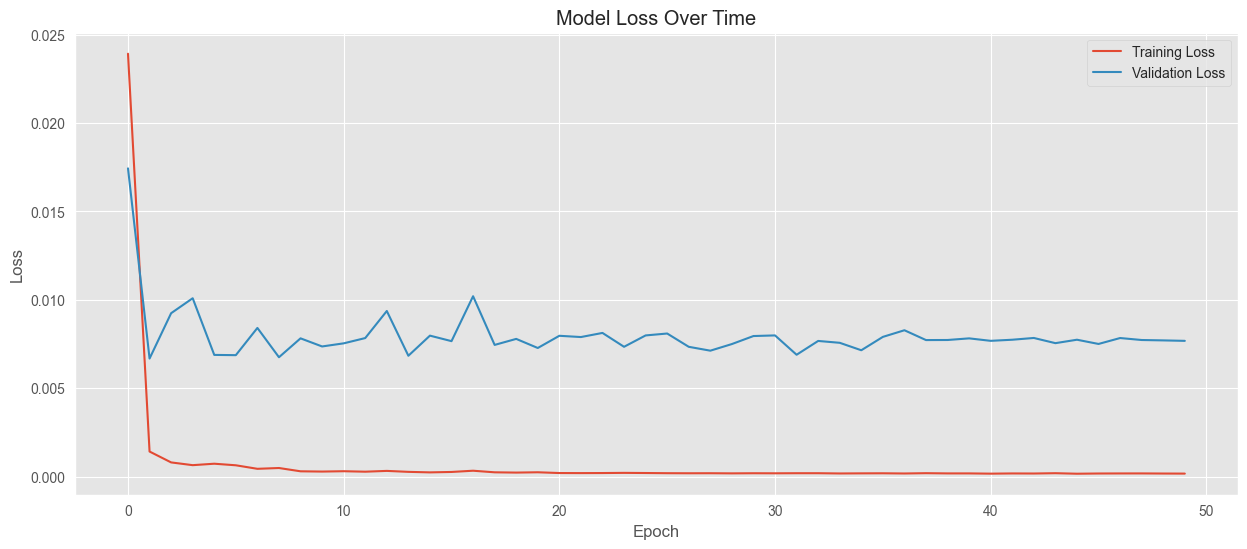

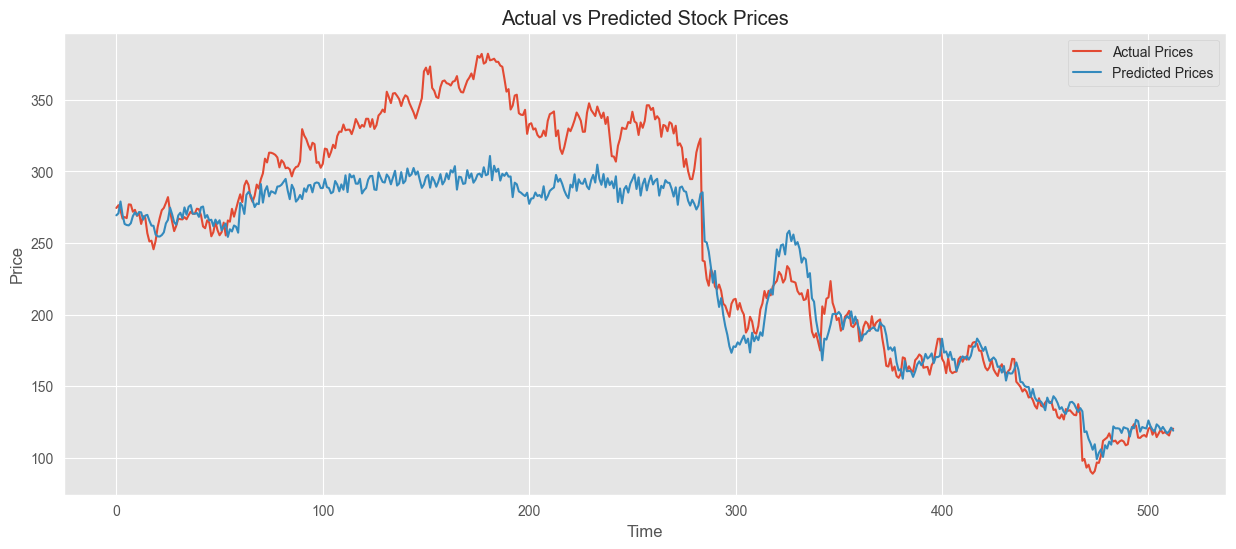

In [33]:
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted prices
plt.figure(figsize=(15, 6))
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]
plt.plot(actual_prices, label='Actual Prices')
plt.plot(val_predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [34]:
# Calculate performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get actual values
actual_vals = actual_prices

# Calculate metrics
mse = mean_squared_error(actual_vals, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_vals, val_predictions)
r2 = r2_score(actual_vals, val_predictions)

# Print metrics
print("\nModel Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")


Model Performance Metrics:
MSE: 1062.851
RMSE: 32.601
MAE: 24.065
R2 Score: 0.849
